In [3]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np
import keras

2024-09-24 12:54:34.720588: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 12:54:34.721902: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-24 12:54:34.772562: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-24 12:54:34.986606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 12:54:36.498279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TR

In [4]:
#vamos abrir os arquivos root
nome1="vhcc_tree.root"
nome2="dyll-nlo_tree.root"
file1= ROOT.TFile.Open( nome1 , "READ" )
file2= ROOT.TFile.Open( nome2, "READ" )

In [5]:
#vamos pegar a TTree
tree1 = file1.Get("Events")
tree2 = file2.Get("Events")

In [6]:
#coletando os dados
from data_classes import Data

data_1=Data()
data_2=Data()

n_max_1=tree1.GetEntries()

for entryNum in range (0 ,n_max_1):
    tree1.GetEntry( entryNum )
    data_1.ak15_regressed_mass.append(getattr(tree1, "ak15_regressed_mass"))

n_max_2=tree2.GetEntries()

for entryNum in range (0 ,n_max_2):
    tree2.GetEntry( entryNum )
    data_2.ak15_regressed_mass.append(getattr(tree2, "ak15_regressed_mass"))   

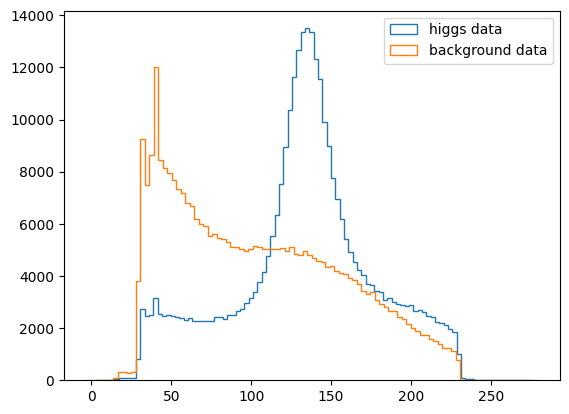

In [7]:
#plotando histograma de massa?

plt.hist( data_1.ak15_regressed_mass,bins=100,fill=False, histtype='step', label="higgs data")
plt.hist( data_2.ak15_regressed_mass[:n_max_1],bins=100, fill=False, histtype='step', label="background data")
plt.legend()

plt.draw()

In [8]:
#arranjando os dados de forma aleatoria

data=Data()

random1=np.random.choice(n_max_1,n_max_1,replace=False) #inteiros ate o primeiro numero. Numero de eventos sorteados igual ao segundo numero
random2=np.random.choice(n_max_2,n_max_1,replace=False)
random_position=np.random.choice(2*n_max_1,n_max_1,replace=False)

is_here=np.zeros(n_max_1*2)
is_here[random_position] = 1


cont1=0
cont2=0

for cont in range(n_max_1*2):
    if is_here[cont]==0:
        data.ak15_regressed_mass.append(data_1.ak15_regressed_mass[random1[cont1]])
        data.truth.append(1)
        cont1=cont1+1
    if is_here[cont]==1:
        data.ak15_regressed_mass.append(data_2.ak15_regressed_mass[random2[cont2]])
        data.truth.append(0)
        cont2=cont2+1   

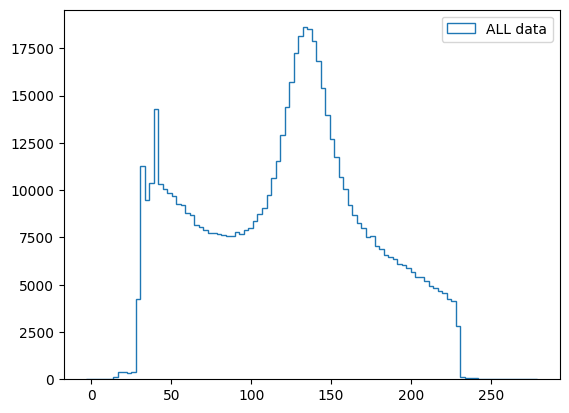

In [9]:
#plotando o histograma total de massa

plt.hist( data.ak15_regressed_mass,bins=100, fill=False, histtype='step', label="ALL data")
plt.legend()
plt.draw()

In [10]:
#modelo da rede neural sendo montado

from keras import models,layers,initializers

model= models.Sequential(name="my_neural")
model.add(layers.Input(shape=(1,)))
model.add(layers.Dense(8,activation="relu"))
model.add(layers.Dense(8,activation="relu"))
model.add(layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])



In [11]:
#separando os dados
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data.ak15_regressed_mass,data.truth,random_state=42)
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

In [12]:
model.summary()

Model: "my_neural"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
#treino
history = model.fit(x_train,y_train,epochs=100,batch_size=15000,validation_data=(x_test,y_test))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5001 - loss: 18.4263 - val_accuracy: 0.5004 - val_loss: 11.0855
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5005 - loss: 8.7028 - val_accuracy: 0.5004 - val_loss: 1.7705
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5081 - loss: 1.0682 - val_accuracy: 0.5177 - val_loss: 0.7255
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5506 - loss: 0.6938 - val_accuracy: 0.6300 - val_loss: 0.6794
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6356 - loss: 0.6799 - val_accuracy: 0.6354 - val_loss: 0.6792
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6305 - loss: 0.6793 - val_accuracy: 0.6274 - val_loss: 0.6789
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6298 - loss: 0.6787 - val_accuracy: 0.6379 - val_loss: 0.6785
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6360 - loss: 0.6785 - val_accuracy: 0.6330 

In [14]:
# Accessing the training loss history
training_loss = history.history['loss']

# Accessing the validation loss history
validation_loss = history.history['val_loss']

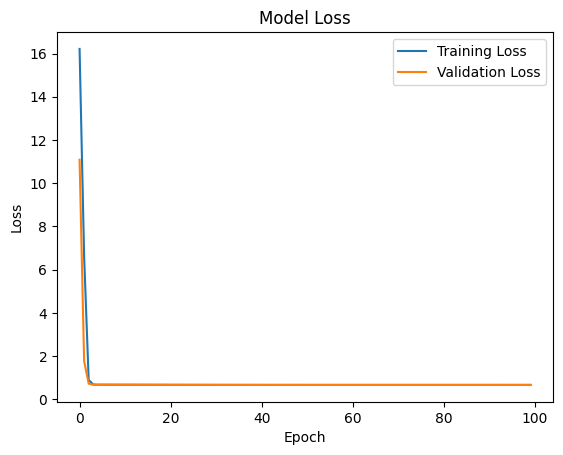

In [15]:
# Plot training & validation loss values
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
y_pred_prob = model.predict(x_test) 

5192/5192 ━━━━━━━━━━━━━━━━━━━━ 3s 618us/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


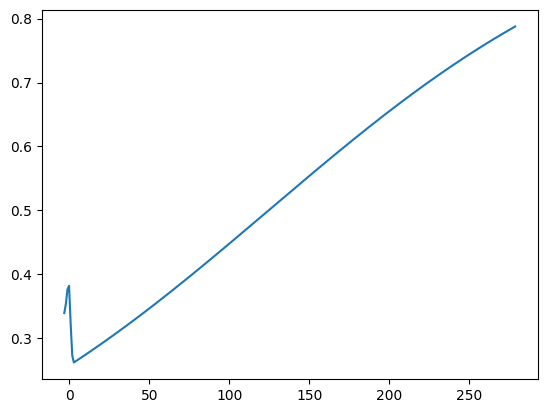

In [17]:
min_x=np.min(x_test)
max_x=np.max(x_test)

x_range=np.arange(min_x,max_x,1)
y_range=model.predict(x_range) 
plt.plot(x_range,y_range)

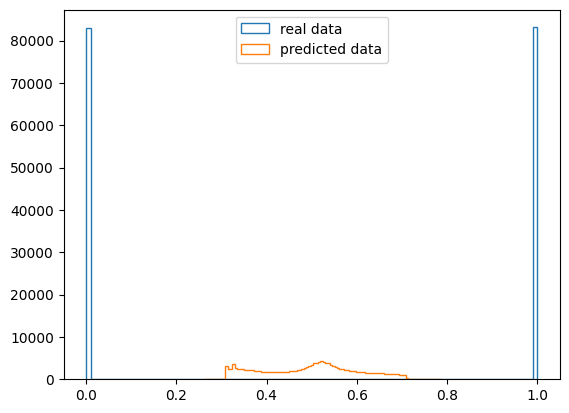

In [18]:
#plotando histograma da previsao e do valor real

plt.hist(y_test, bins=100, fill=False, histtype='step', label="real data")
plt.hist(y_pred_prob,bins=100, fill=False, histtype='step', label="predicted data")
plt.legend()

plt.show()

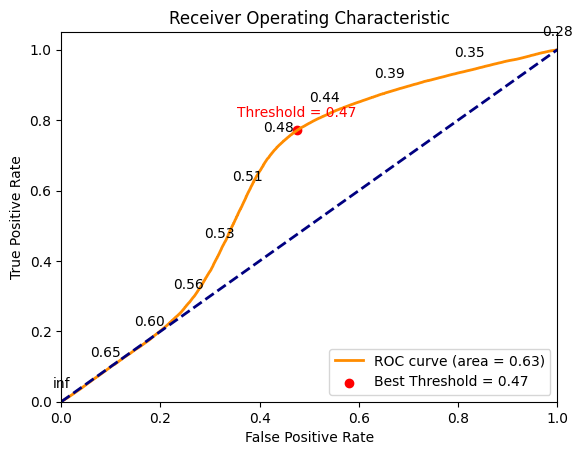

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

#best threshold
J = tpr - fpr
best_threshold_index = np.argmax(J)
best_threshold = thresholds[best_threshold_index]

# Annotate some thresholds on the ROC curve
for i in range(0, len(thresholds), len(thresholds) // 10):
    plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Highlight the best threshold point
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.annotate(f'Threshold = {best_threshold:.2f}', 
             (fpr[best_threshold_index], tpr[best_threshold_index]), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center', 
             color='red')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()